In [32]:
ENV["PYTHONPATH"]="/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg";
# Required for SymmetryBases.jl

In [33]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables, Brillouin
using PyCall, Statistics
np = pyimport("numpy")
include("plotting_utilities.jl") # Julia file for plotting unit cells in an aesthetically pleasing way
cm = 1/2.54;
include("get-freqs-symeigs.jl");

In [3]:
# K points used for the nodal point calculations
ks = Vector{Vector{Float64}}()
N = 500
for i in 1:N+1
for j in 1:N+1
    kx = (i-1)/N - 0.5
    ky = (j-1)/N - 0.5
    push!(ks, [kx, ky])
end
end
#=for idx in 1:200
    open("nodal_points/input/kpoints-$idx.sh", "w") do io 
        write(io, "kvecs=(list ")
        for k in ks[idx:200:length(ks)]
            kx, ky = k
            write(io, "(vector3 $(kx) $(ky)) ")
        end
        write(io, ")")
    end
end=#

In [4]:
# Check kpoints are consistent with jld2 file in which we saved the input parameters fromf kpoint-$idx.sh files
input_dir = "./nodal_points/input/"
kpointsv = load(input_dir * "kpoints.jld2")["kpointsv"];

for (i, kpoints_str) in enumerate(kpointsv)
    line = filter(x-> startswith(x, "kvecs"), split(kpoints_str, "\n"))[1]
    kvecs = [replace(x, ")"=>"", "("=>"") for x in split(line, "(vector3 ")][2:end]
    dispersion_kpts = [parse.(Float64, split(kvec)) for kvec in kvecs]
    @assert dispersion_kpts == ks[i:200:end]
end

In [4]:
# Function transforms a vector k that is in the reciprocal basis to the cartesian basis
function wigner_seitz(k::Vector{<:Real}, Gs::ReciprocalBasis)
    b1, b2 = Gs
    kbasis = hcat(b1, b2)
    return kbasis*k
end;
function wigner_seitz_inv(k::Vector{<:Real}, Gs::ReciprocalBasis)
    b1, b2 = Gs
    kbasis = hcat(b1, b2)
    return inv(kbasis)*k
end;

In [5]:
good_candidatesv = Dict{Tuple{String, Integer, Integer, Integer}, Float64}[] #mode, id_eps, id, top band, margin (total id including id_eps offset) 
                                                                # This is a vector- each element corresponds to sgs 2, 10, 16 respectively
for sg in [2, 10, 16]
    println("Calculating for sg: $sg"); flush(stdout)
    good_candidates = Dict{Tuple{String, Integer, Integer, Integer}, Float64}() # Dictionary for each space group
    for id_eps in 1:3
        println("Calculating for id_eps: $id_eps"); flush(stdout)
        for mode = ["te", "tm"];
            dispersion_dir = "./dispersions/output/sg$sg/eps$(id_eps)/$mode/";
            loaded_dispersion_data = load(dispersion_dir*"sg$sg-epsid$(id_eps)-res64-$mode.jld2")
            marginsv = loaded_dispersion_data["marginsv"];
            cumsummariesv = loaded_dispersion_data["cumsummariesv"];
            for (id, (margins, cumsummaries)) in enumerate(zip(marginsv, cumsummariesv))
                real_id = id + (10000)*(id_eps-1)
                for (cumsum_idx, (margin, cumsummary)) in enumerate(zip(margins, cumsummaries))
                    if cumsum_idx <= 3 # We only want candidates with nontrivial bands at low frequencies (below third multiplet)
                        cumsummary.topology == NONTRIVIAL || continue
                        top_band = cumsummary.band[end]
                        push!(good_candidates, (mode, id_eps, real_id, top_band) => margin)
                    end
                end
            end
        end
    end
    push!(good_candidatesv, good_candidates)
end

Calculating for sg: 2
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3
Calculating for sg: 10
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3
Calculating for sg: 16
Calculating for id_eps: 1
Calculating for id_eps: 2
Calculating for id_eps: 3


In [6]:
nodal_point_calcnames = String[]
nodal_point_data = Dict{String, Tuple{Float64, Integer, String, Integer, Integer}}() # margin, id_eps, mode, id, top_band 
for (good_candidates, sg) in zip(good_candidatesv, [2, 10, 16])
    best_candidates = collect(sort(good_candidates, byvalue=true, rev=true))
    for best_candidate in best_candidates[1:10]
        (mode, id_eps, id, band), margin = best_candidate #findmax(good_candidates)
        push!(nodal_point_data, "dim2-sg$sg-$id-res64-$mode" => (margin, id_eps, mode, id, band))
        push!(nodal_point_calcnames, "dim2-sg$sg-$id-res64-$mode")
    end
end

In [7]:
loaded_logs = load("nodal_points/logs/nodal_point_logs.jld2");

dim2-sg2-29481-res64-te
2
dim2-sg2-20482-res64-te
2
dim2-sg2-21585-res64-te
2
dim2-sg2-25798-res64-te
2
dim2-sg2-23907-res64-te
2
dim2-sg2-22469-res64-te
2
dim2-sg2-23318-res64-te
2
dim2-sg2-10482-res64-te
2
dim2-sg2-28730-res64-te
2
dim2-sg2-19491-res64-te
2
dim2-sg10-4531-res64-te
4
dim2-sg10-15403-res64-te
4
dim2-sg10-26981-res64-te
4
dim2-sg10-20683-res64-te
4
dim2-sg10-13730-res64-te
4
dim2-sg10-27456-res64-te
4
dim2-sg10-12143-res64-te
4
dim2-sg10-10683-res64-te
4
dim2-sg10-14531-res64-te
4
dim2-sg10-23364-res64-te
5
dim2-sg16-18359-res64-te
8
dim2-sg16-145-res64-te
9
dim2-sg16-458-res64-te
9
dim2-sg16-18375-res64-te
8
dim2-sg16-9809-res64-te
8
dim2-sg16-28375-res64-te
8
dim2-sg16-28359-res64-te
8
dim2-sg16-4498-res64-te
8
dim2-sg16-9993-res64-tm
6
dim2-sg16-13902-res64-te
8


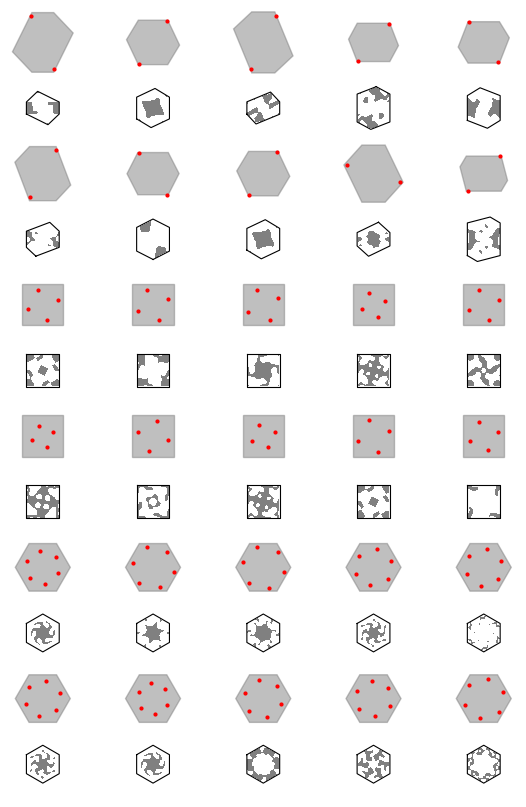

In [30]:
# Figure S9

fig = figure(figsize=(14*cm, 20*cm))
for (i, nodal_point_calcname) in enumerate(nodal_point_calcnames)
    println(nodal_point_calcname); flush(stdout)
    sgnum = MPBUtils.parse_sgnum(nodal_point_calcname)

    calc_idx = parse(Int64, String(split(nodal_point_calcname, "-")[3]))
    calc_idx = mod(calc_idx - 1, 10000) + 1 

    num_nodal_points = 
        if sgnum == 2
            2
        elseif sgnum == 10 
            4
        else 
            6
        end
    
    input_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
    input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
    
    loaded_input_data = load(input_dir * input_filename)

    Rsv = loaded_input_data["Rsv"]
    flatv = loaded_input_data["flatv"]
    isovalv = loaded_input_data["isovalv"]

    Rs, flat, isoval = Rsv[calc_idx], flatv[calc_idx], isovalv[calc_idx]
    
    subplot(12, 5, i+5*div(i-1, 5))
    margin, id_eps, mode, real_id, top_band = nodal_point_data[nodal_point_calcname]
    println(top_band); flush(stdout)
    band1 = zeros(501*501)
    band2 = zeros(501*501)
    all_bands = zeros(501*501, 11)
    logsv = loaded_logs["sg$(sgnum)/$(nodal_point_calcname)/logsv"]

    for idx in 1:200
        logs = logsv[idx]
        dispersion = logs_to_dispersion(logs)
        dispersion_io = IOBuffer(dispersion)
        dispersion = readdlm(dispersion_io, ',')::Matrix{Float64}
        close(dispersion_io)

        dispersion = sort(dispersion[:, 6:end], dims = 2)
        lower_dispersion = dispersion[:, top_band]
        upper_dispersion = dispersion[:, top_band+1]
        gap = minimum(upper_dispersion - lower_dispersion)
        gap < 0 && (println("Negative Gap at idx: $idx"); flush(stdout); println(argmin(upper_dispersion - lower_dispersion)))
        band1[idx:200:end] =  lower_dispersion 
        band2[idx:200:end] =  upper_dispersion 
        all_bands[idx:200:end, :] = dispersion
    end
    xs = Float64[]
    ys = Float64[]
    
    Gs = reciprocalbasis(Rs)
    verts = wignerseitz(Gs).verts;
    faces = wignerseitz(Gs).faces;
    for vert in verts
        x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
        push!(xs, x)
        push!(ys, y)
    end
    fill(xs, ys, alpha=0.5, color="grey")
    polygon = shapely_polygon([[x, y] for (x, y) in zip(xs, ys)])
    xlim(-5, 5)
    ylim(-5, 5)
    xticks(Float64[])
    yticks(Float64[])
    theta = 2π/num_nodal_points
    rotation_matrix = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    nodal_point_value = band1[argmin(band2 - band1)]
    for idx_1 in -1:1
        for idx_2 in -1:1
            for i in 1:num_nodal_points
                k = (rotation_matrix^i) * wigner_seitz(ks[argmin(band2-band1)] + [idx_1, idx_2], Gs)
                #k in nodal_point_locations
                polygon.contains(shapely_point(k)) || continue
                scatter(k..., color="red", s = 4)
            end
        end
    end
    
    xleft, xright = gca().get_xlim()
    ydown, yup = gca().get_ylim()
    gca().set_aspect("equal", adjustable="box")
    gca().set_axis_off()
    subplot(12, 5, i+5+5*div(i-1, 5))

    wigner_cell = wignerseitz(Rs)
    wigner_plot(flat, Rs, wigner_cell; isoval=isoval, fig=fig, ax=gca(), translation_vector=[0, 0], xyz = range(-1, 1, length=500), 
    in_polygon=true);#gca().set_axis_on()
end
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0) # In order to get rid of extraneous white space
#savefig("./Nodal_Point_Figs/all_nodal_points.pdf")


In [8]:
non_duplicate_ks_idx  = findall(x->x[1] !=0.5 && x[2] != 0.5, ks);

dim2-sg2-29481-res64-te
2
dim2-sg2-20482-res64-te
2
dim2-sg2-21585-res64-te
2
dim2-sg2-25798-res64-te
2
dim2-sg2-23907-res64-te
2
dim2-sg2-22469-res64-te
2
dim2-sg2-23318-res64-te
2
dim2-sg2-10482-res64-te
2
dim2-sg2-28730-res64-te
2
dim2-sg2-19491-res64-te
2
dim2-sg10-4531-res64-te
4
dim2-sg10-15403-res64-te
4
dim2-sg10-26981-res64-te
4
dim2-sg10-20683-res64-te
4
dim2-sg10-13730-res64-te
4
dim2-sg10-27456-res64-te
4
dim2-sg10-12143-res64-te
4
dim2-sg10-10683-res64-te
4
dim2-sg10-14531-res64-te
4
dim2-sg10-23364-res64-te
5
dim2-sg16-18359-res64-te
8
dim2-sg16-145-res64-te
9
dim2-sg16-458-res64-te
9
dim2-sg16-18375-res64-te
8
dim2-sg16-9809-res64-te
8
dim2-sg16-28375-res64-te
8
dim2-sg16-28359-res64-te
8
dim2-sg16-4498-res64-te
8
dim2-sg16-9993-res64-tm
6
dim2-sg16-13902-res64-te
8


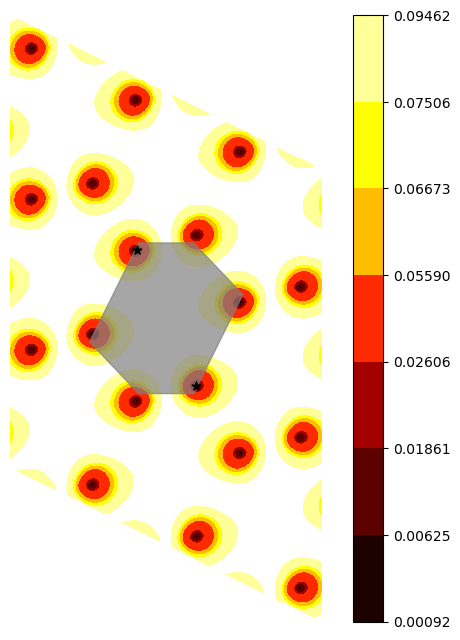

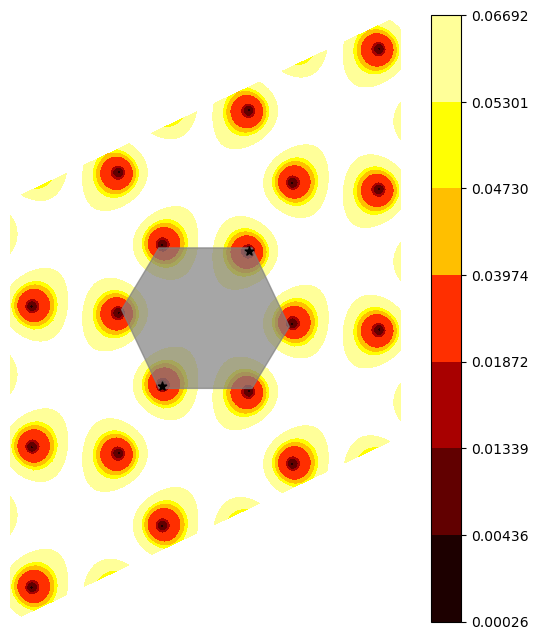

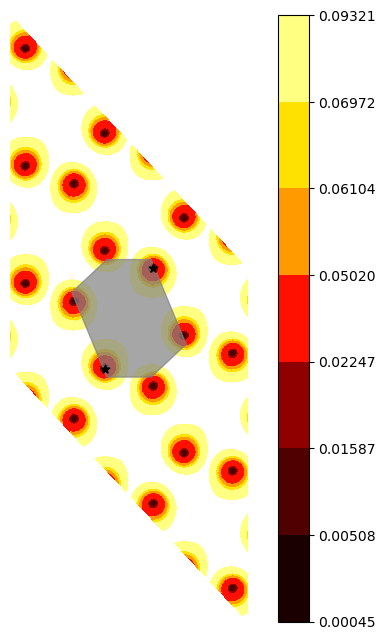

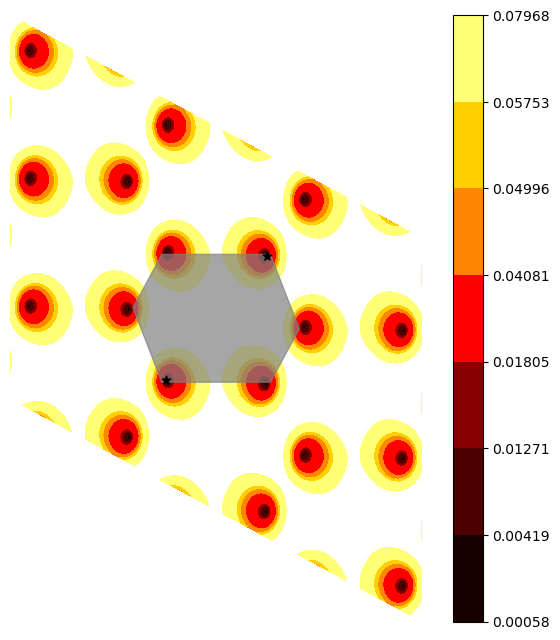

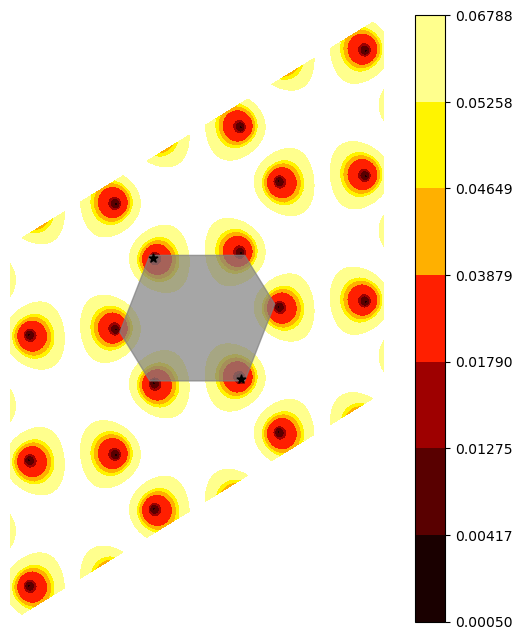

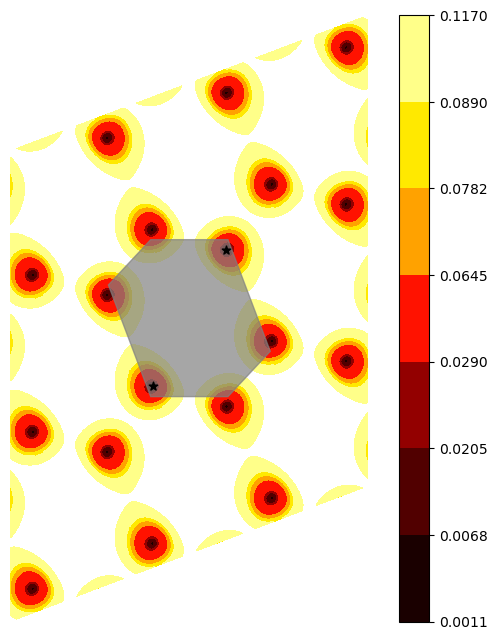

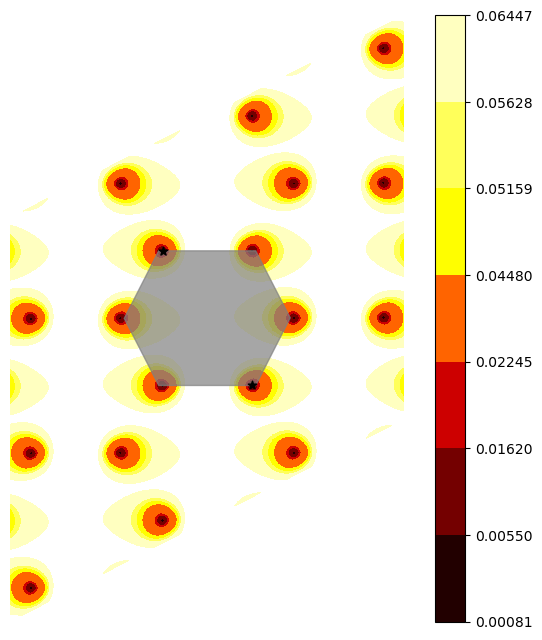

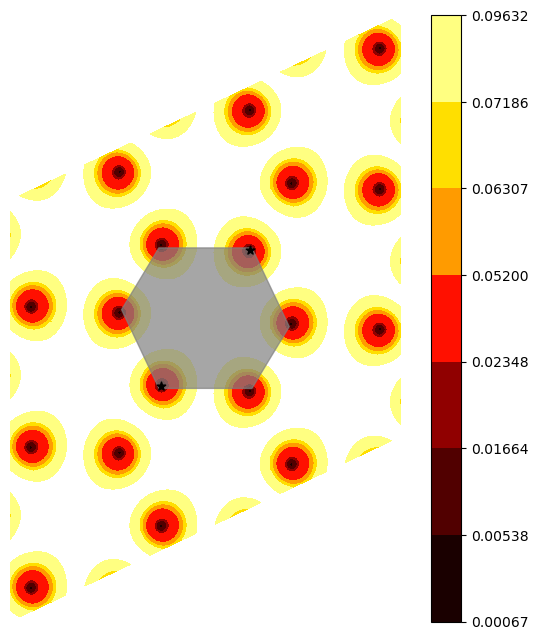

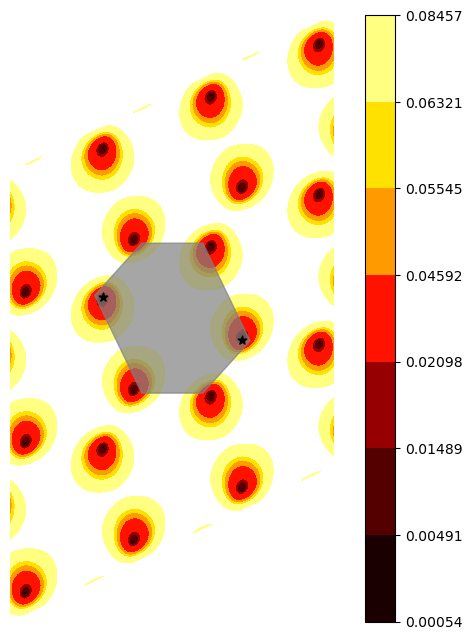

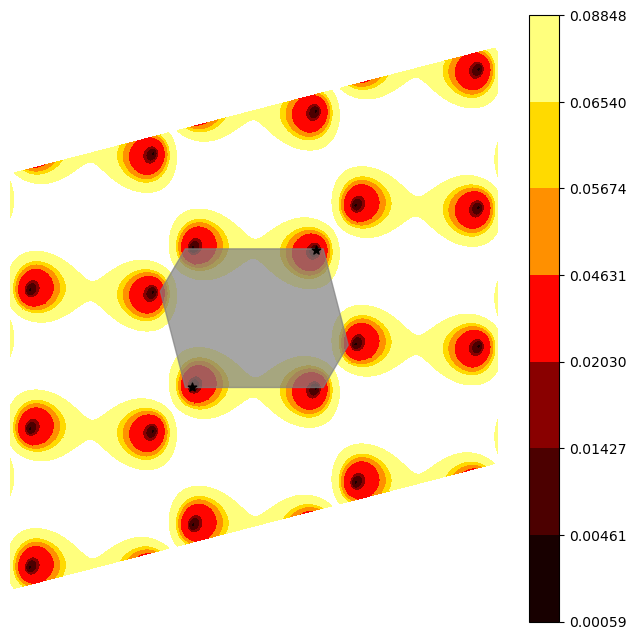

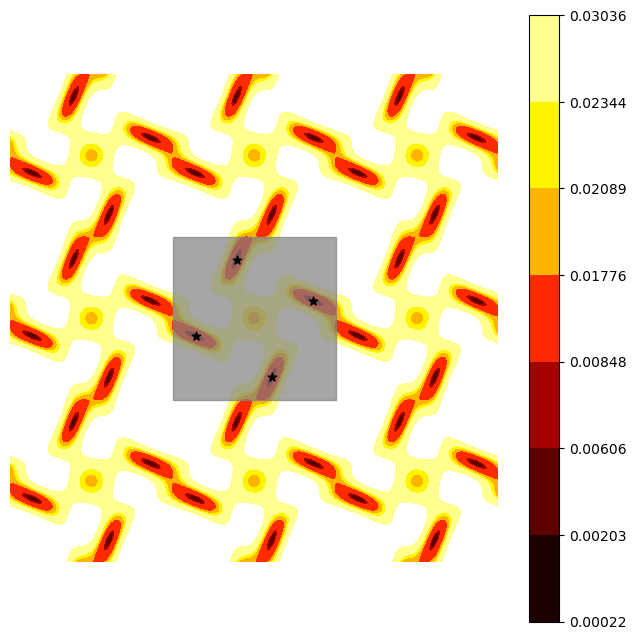

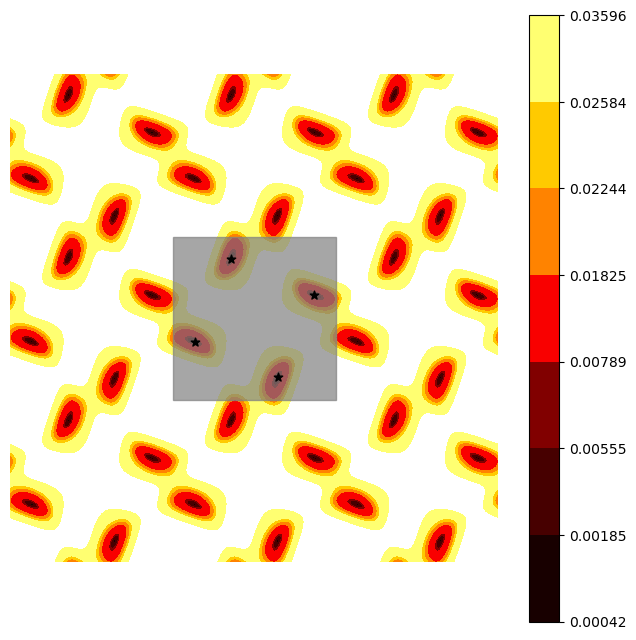

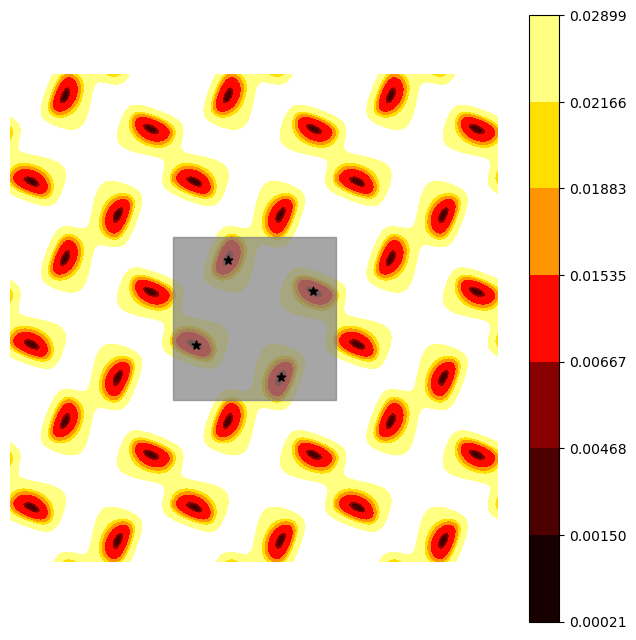

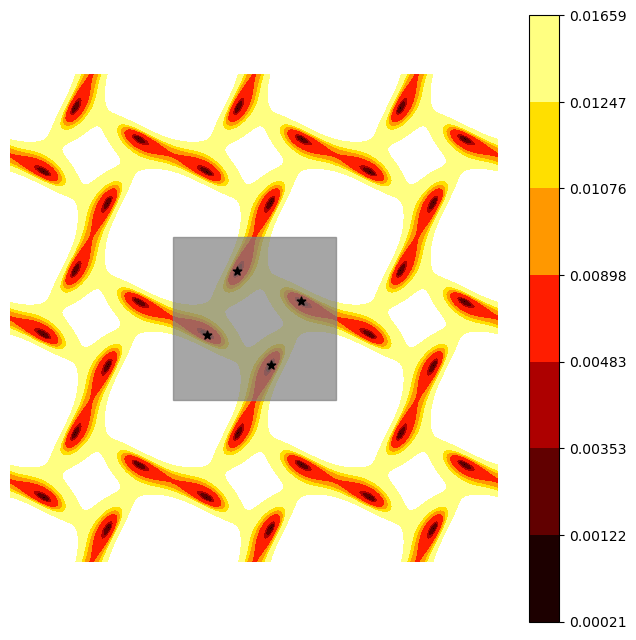

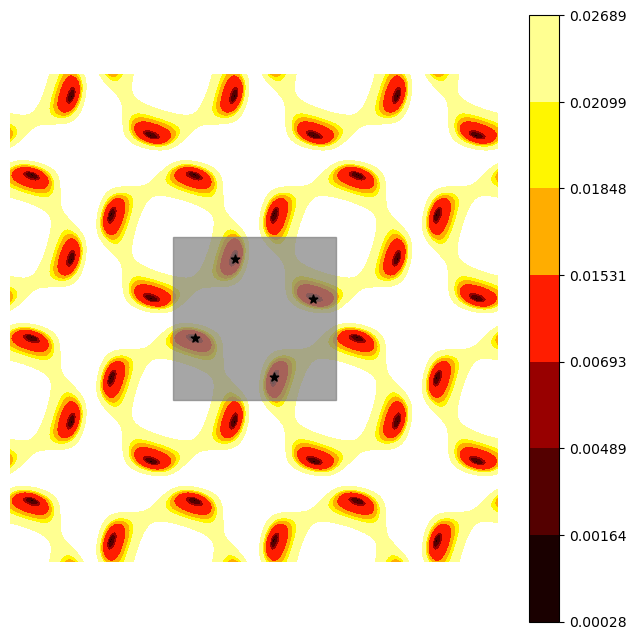

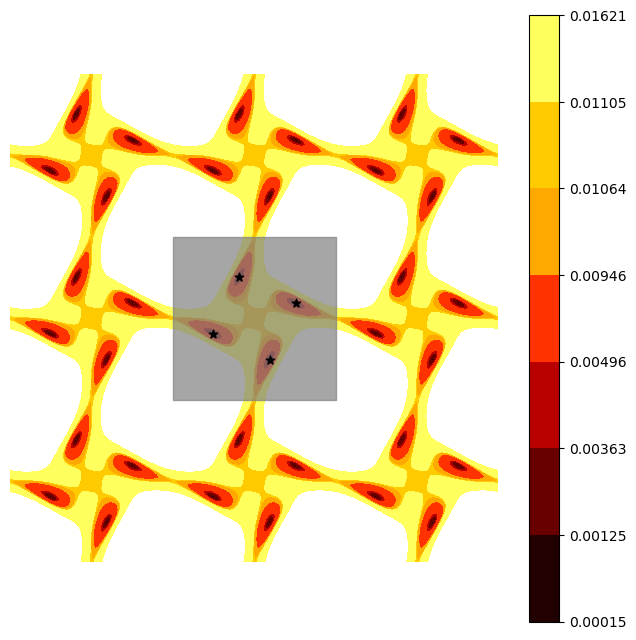

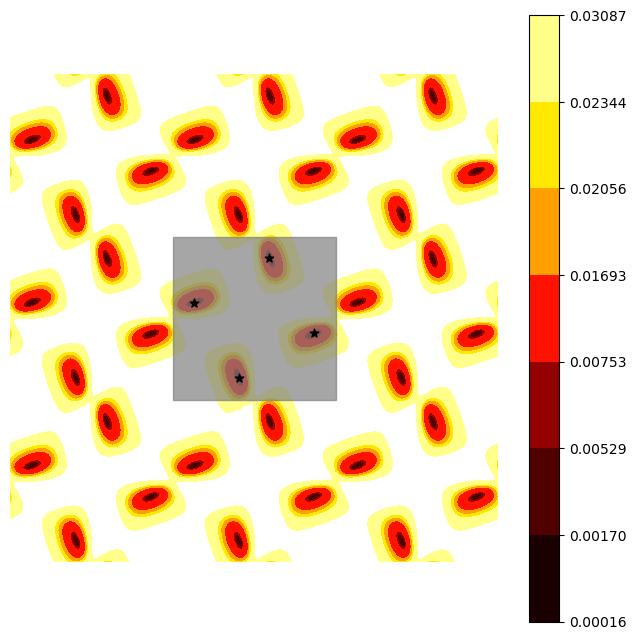

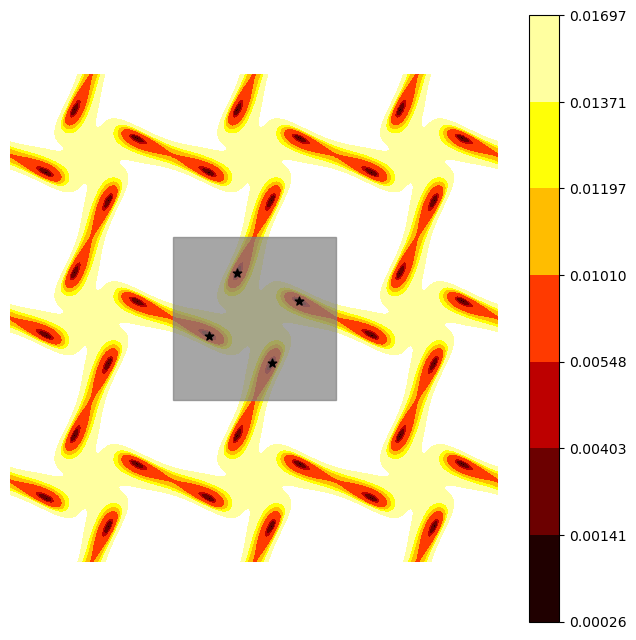

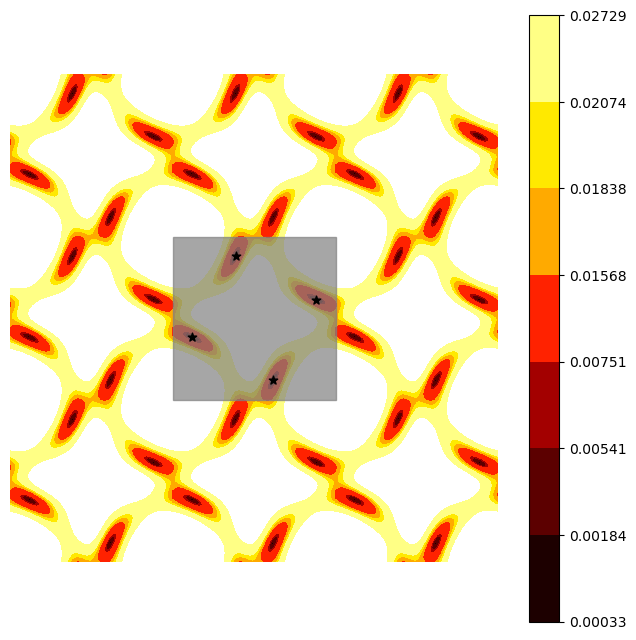

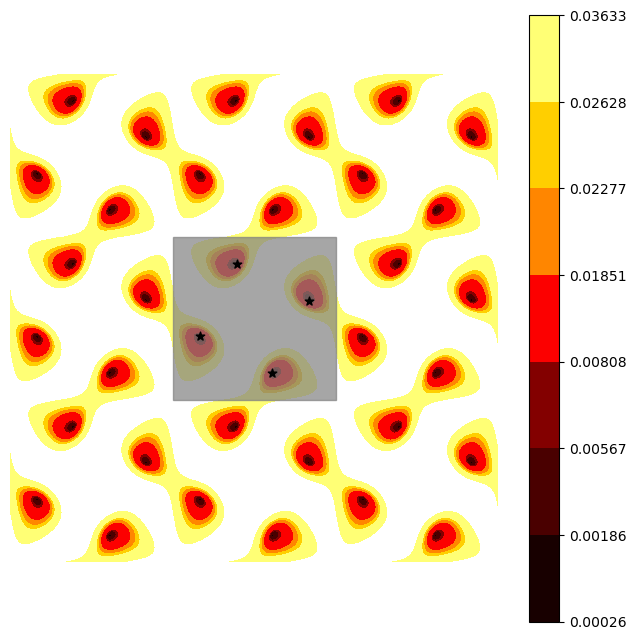

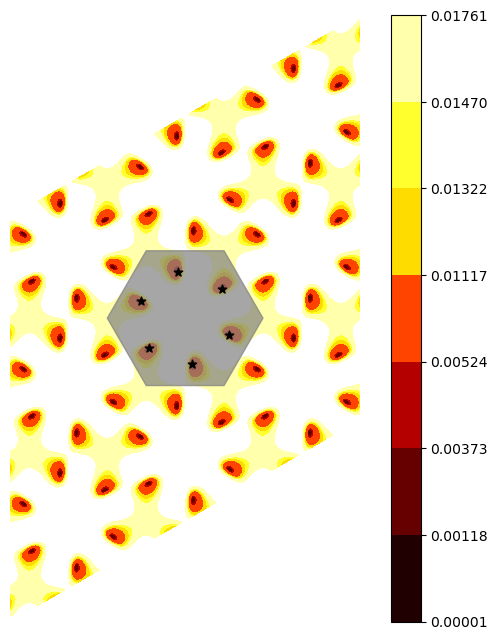

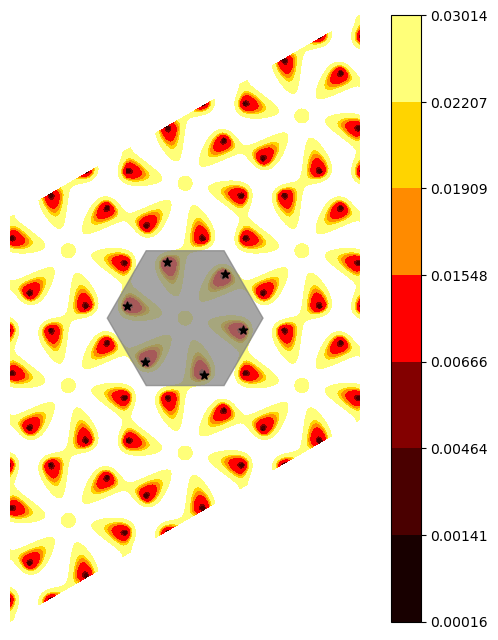

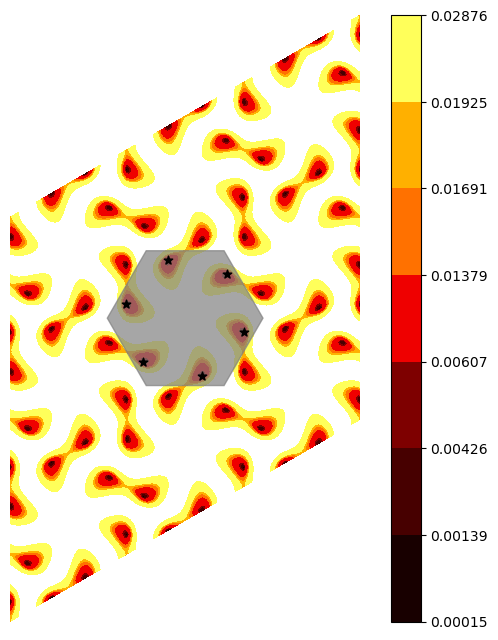

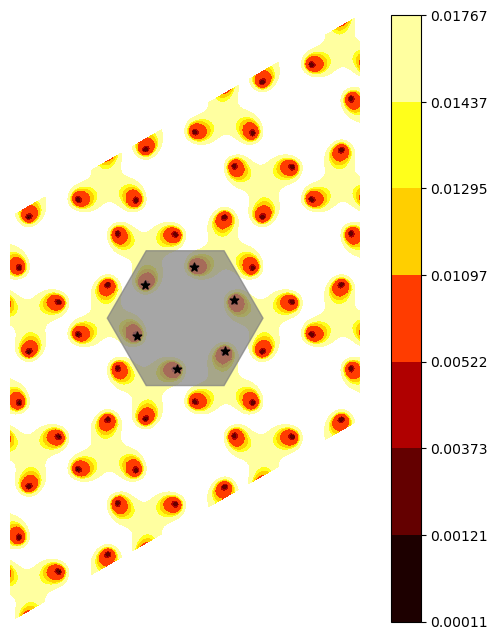

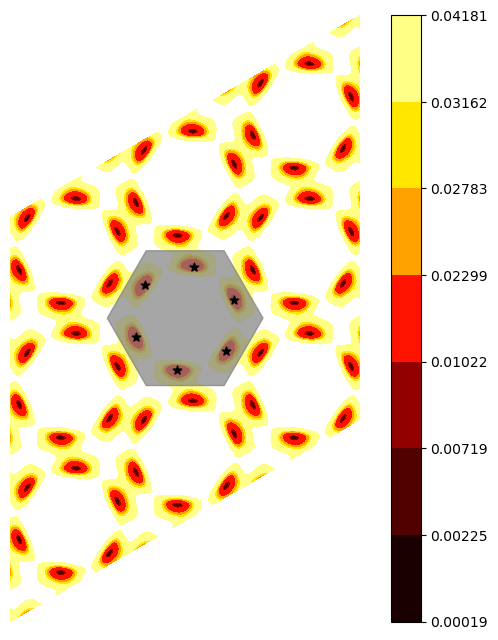

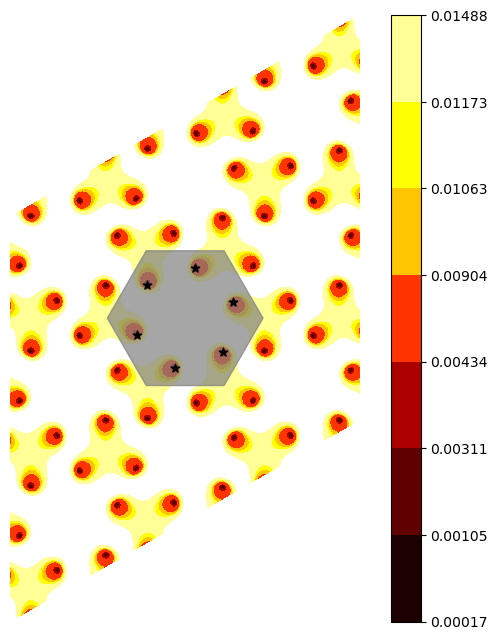

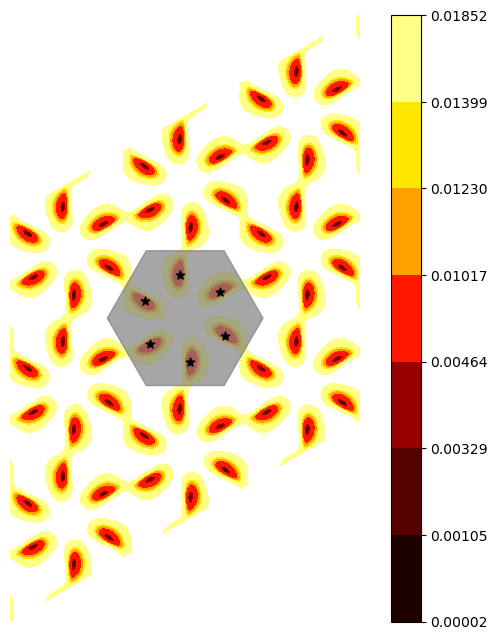

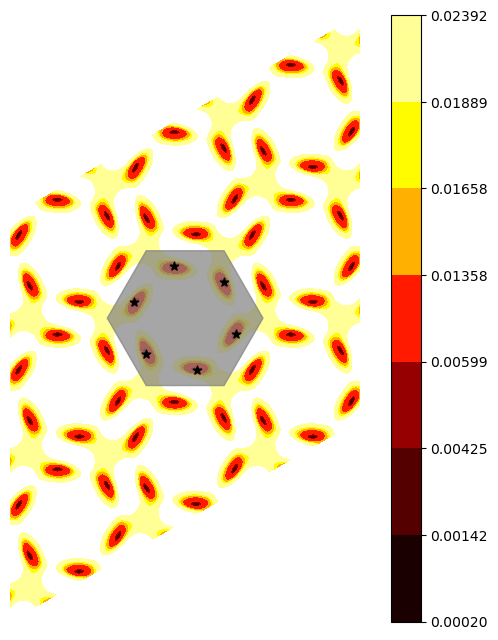

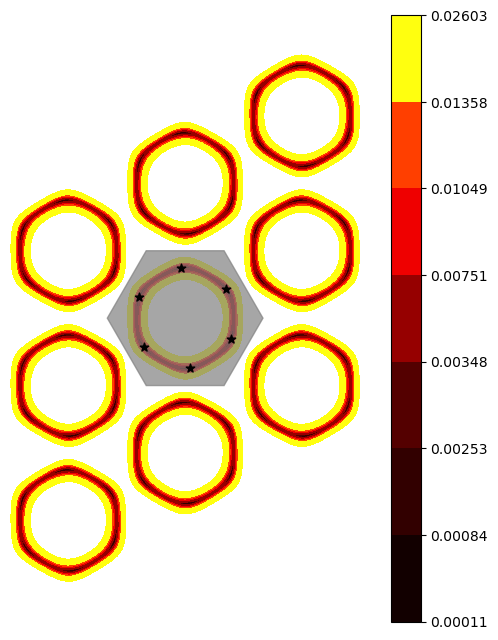

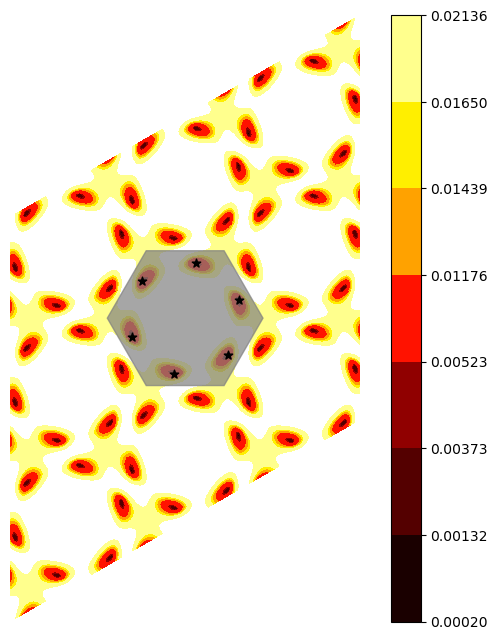

In [67]:
# Below we'll check that the nodal point locations are correct by superimposing them on contour plots
for (i, nodal_point_calcname) in enumerate(nodal_point_calcnames)
    figure(figsize=(20*cm, 20*cm))
    println(nodal_point_calcname); flush(stdout)
    sgnum = MPBUtils.parse_sgnum(nodal_point_calcname)
    
    calc_idx = parse(Int64, String(split(nodal_point_calcname, "-")[3]))
    calc_idx = mod(calc_idx - 1, 10000) + 1 
    
    input_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
    input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
    
    loaded_input_data = load(input_dir * input_filename)
    
    Rsv = loaded_input_data["Rsv"]
    Rs = Rsv[calc_idx]
    
    num_nodal_points = 
        if sgnum == 2
            2
        elseif sgnum == 10 
            4
        else 
            6
        end
        
    margin, id_eps, mode, real_id, top_band = nodal_point_data[nodal_point_calcname]
    println(top_band); flush(stdout)
    band1 = zeros(501*501)
    band2 = zeros(501*501)
    logsv = loaded_logs["sg$(sgnum)/$(nodal_point_calcname)/logsv"]
    
    for idx in 1:200
        logs = logsv[idx]
        dispersion = logs_to_dispersion(logs)
        dispersion_io = IOBuffer(dispersion)
        dispersion = readdlm(dispersion_io, ',')::Matrix{Float64}
        close(dispersion_io)
    
        dispersion = sort(dispersion[:, 6:end], dims = 2)
        lower_dispersion = dispersion[:, top_band]
        upper_dispersion = dispersion[:, top_band+1]
        gap = minimum(upper_dispersion - lower_dispersion)
        gap < 0 && (println("Negative Gap at idx: $idx"); flush(stdout); println(argmin(upper_dispersion - lower_dispersion)))
        band1[idx:200:end] =  lower_dispersion 
        band2[idx:200:end] =  upper_dispersion 
    end
    xs = Float64[]
    ys = Float64[]
    
    Gs = reciprocalbasis(Rs)
    verts = wignerseitz(Gs).verts;
    faces = wignerseitz(Gs).faces;
    for vert in verts
        x, y = Gs[1]*vert[1] + Gs[2]*vert[2]
        push!(xs, x)
        push!(ys, y)
    end
    polygon = shapely_polygon([[x, y] for (x, y) in zip(xs, ys)])
    xticks(Float64[])
    yticks(Float64[])
    theta = 2π/num_nodal_points
    rotation_matrix = [cos(theta) -sin(theta); sin(theta) cos(theta)]
    nodal_point_value = band1[argmin(band2 - band1)]
    

    res_len = 500 
    idx_range = -1:1
    idx_len = length(idx_range)
    band2_mat = reshape(band2[non_duplicate_ks_idx] .- nodal_point_value, (res_len, res_len))
    band2_quantiles = quantile(band2 .- nodal_point_value, [0, 0.001, 0.01, 0.02, 0.1, 0.15, 0.2, 0.4])
    for idx_1 in idx_range
        for idx_2 in idx_range
        X = reshape([wigner_seitz(k + [idx_1, idx_2], Gs)[1] for k in ks[non_duplicate_ks_idx ]], (res_len, res_len)) 
        Y= reshape([wigner_seitz(k + [idx_1, idx_2], Gs)[2] for k in ks[non_duplicate_ks_idx ]], (res_len, res_len)) 
        contourf(X, Y, band2_mat, cmap="hot", levels=band2_quantiles)
        end
    end
    colorbar()
    fill(xs, ys, alpha=0.7, color="grey")    

    for idx_1 in -1:1
        for idx_2 in -1:1
            for i in 1:num_nodal_points
                k = (rotation_matrix^i) * wigner_seitz(ks[argmin(band2-band1)] + [idx_1, idx_2], Gs)
                #k in nodal_point_locations
                polygon.contains(shapely_point(k)) || continue
                scatter(k..., color="black", s = 40, marker="*")
            end
        end
    end
    
    xleft, xright = gca().get_xlim()
    ydown, yup = gca().get_ylim()
    gca().set_aspect("equal", adjustable="box")
    gca().set_axis_off()
end
    #savefig("./Nodal_Point_Figs/all_nodal_points.pdf")


In [48]:
# Check kpoints consistent
for nodal_point_calcname in nodal_point_calcnames
    sgnum = MPBUtils.parse_sgnum(nodal_point_calcname)
    println(nodal_point_calcname); flush(stdout)
    logsv = loaded_logs["sg$(sgnum)/$(nodal_point_calcname)/logsv"]
    for i in 1:200
        #println(i); flush(stdout)
        logs = logsv[i]
        kpoints_lines = filter(x -> contains(x, "kvecs"), split(logs, "\n"))
        kpoints_line = kpoints_lines[end] # Only look at last command line parameter
        kvecs = [replace(x, ")"=>"", "("=>"") for x in split(kpoints_line, "(vector3 ")][2:end]
        dispersion_kpts = [parse.(Float64, split(kvec)) for kvec in kvecs]
        @assert dispersion_kpts == ks[i:200:end]
    end
end

dim2-sg2-29481-res64-te
dim2-sg2-20482-res64-te
dim2-sg2-21585-res64-te
dim2-sg2-25798-res64-te
dim2-sg2-23907-res64-te
dim2-sg2-22469-res64-te
dim2-sg2-23318-res64-te
dim2-sg2-10482-res64-te
dim2-sg2-28730-res64-te
dim2-sg2-19491-res64-te
dim2-sg10-4531-res64-te
dim2-sg10-15403-res64-te
dim2-sg10-26981-res64-te
dim2-sg10-20683-res64-te
dim2-sg10-13730-res64-te
dim2-sg10-27456-res64-te
dim2-sg10-12143-res64-te
dim2-sg10-10683-res64-te
dim2-sg10-14531-res64-te
dim2-sg10-23364-res64-te
dim2-sg16-18359-res64-te
dim2-sg16-145-res64-te
dim2-sg16-458-res64-te
dim2-sg16-18375-res64-te
dim2-sg16-9809-res64-te
dim2-sg16-28375-res64-te
dim2-sg16-28359-res64-te
dim2-sg16-4498-res64-te
dim2-sg16-9993-res64-tm
dim2-sg16-13902-res64-te


In [49]:
disp_from_logsd = Dict{String, Vector{String}}() 
for nodal_point_calcname in nodal_point_calcnames
    sgnum = MPBUtils.parse_sgnum(nodal_point_calcname)
    println(nodal_point_calcname); flush(stdout)
    logsv = loaded_logs["sg$sgnum/$(nodal_point_calcname)/logsv"]
    disp_from_logs = Vector{String}()
    for (k_id, logs) in enumerate(logsv)
        push!(disp_from_logs, logs_to_dispersion(logs))
    end
    push!(disp_from_logsd, nodal_point_calcname => disp_from_logs)
end

dim2-sg2-29481-res64-te
dim2-sg2-20482-res64-te
dim2-sg2-21585-res64-te
dim2-sg2-25798-res64-te
dim2-sg2-23907-res64-te
dim2-sg2-22469-res64-te
dim2-sg2-23318-res64-te
dim2-sg2-10482-res64-te
dim2-sg2-28730-res64-te
dim2-sg2-19491-res64-te
dim2-sg10-4531-res64-te
dim2-sg10-15403-res64-te
dim2-sg10-26981-res64-te
dim2-sg10-20683-res64-te
dim2-sg10-13730-res64-te
dim2-sg10-27456-res64-te
dim2-sg10-12143-res64-te
dim2-sg10-10683-res64-te
dim2-sg10-14531-res64-te
dim2-sg10-23364-res64-te
dim2-sg16-18359-res64-te
dim2-sg16-145-res64-te
dim2-sg16-458-res64-te
dim2-sg16-18375-res64-te
dim2-sg16-9809-res64-te
dim2-sg16-28375-res64-te
dim2-sg16-28359-res64-te
dim2-sg16-4498-res64-te
dim2-sg16-9993-res64-tm
dim2-sg16-13902-res64-te


In [53]:
for nodal_point_calcname in nodal_point_calcnames
    println("nodal_point_calcname: $(nodal_point_calcname)"); flush(stdout)
    frequencies_strv = disp_from_logsd[nodal_point_calcname]
    for (idx, frequencies_str) in enumerate(frequencies_strv)
        frequencies_io = IOBuffer(frequencies_str)
        log_jld_freqs = readdlm(frequencies_io, ',')::Matrix{Float64}
        dispersion_out_freqs =  readdlm("nodal_points/output/$(nodal_point_calcname)-$idx-dispersion.out", ',', Float64)
        @assert iszero(log_jld_freqs - dispersion_out_freqs)
        close(frequencies_io)
    end
end

nodal_point_calcname: dim2-sg2-29481-res64-te
nodal_point_calcname: dim2-sg2-20482-res64-te
nodal_point_calcname: dim2-sg2-21585-res64-te
nodal_point_calcname: dim2-sg2-25798-res64-te
nodal_point_calcname: dim2-sg2-23907-res64-te
nodal_point_calcname: dim2-sg2-22469-res64-te
nodal_point_calcname: dim2-sg2-23318-res64-te
nodal_point_calcname: dim2-sg2-10482-res64-te
nodal_point_calcname: dim2-sg2-28730-res64-te
nodal_point_calcname: dim2-sg2-19491-res64-te
nodal_point_calcname: dim2-sg10-4531-res64-te
nodal_point_calcname: dim2-sg10-15403-res64-te
nodal_point_calcname: dim2-sg10-26981-res64-te
nodal_point_calcname: dim2-sg10-20683-res64-te
nodal_point_calcname: dim2-sg10-13730-res64-te
nodal_point_calcname: dim2-sg10-27456-res64-te
nodal_point_calcname: dim2-sg10-12143-res64-te
nodal_point_calcname: dim2-sg10-10683-res64-te
nodal_point_calcname: dim2-sg10-14531-res64-te
nodal_point_calcname: dim2-sg10-23364-res64-te
nodal_point_calcname: dim2-sg16-18359-res64-te
nodal_point_calcname: di

In [37]:
# Finally, check that all lattices make sense

In [48]:
for nodal_point_calcname in nodal_point_calcnames
    println("nodal_point_calcname: $(nodal_point_calcname)"); flush(stdout)
    sgnum = MPBUtils.parse_sgnum(nodal_point_calcname)
    calc_idx = parse(Int64, String(split(nodal_point_calcname, "-")[3]))
    calc_idx = mod(calc_idx - 1, 10000) + 1 


    input_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
    input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
    
    loaded_input_data = load(input_dir * input_filename)

    Rsv = loaded_input_data["Rsv"]
    flatv = loaded_input_data["flatv"]
    isovalv = loaded_input_data["isovalv"]

    logsv = loaded_logs["sg$sgnum/$nodal_point_calcname/logsv"]
    for idx in 1:200
        logs = logsv[idx]
        logs_io = IOBuffer(logs)
        Rs_from_logs, flat_from_logs, isoval_from_logs = lattice_from_mpbparams(logs_io)
        Rs, flat, isoval = Rsv[calc_idx], flatv[calc_idx], isovalv[calc_idx]
        @assert Rs_from_logs == Rs
        @assert flat_from_logs == flat
        @assert isoval_from_logs == isoval
        close(logs_io)
    end
end

nodal_point_calcname: dim2-sg2-29481-res64-te
nodal_point_calcname: dim2-sg2-20482-res64-te
nodal_point_calcname: dim2-sg2-21585-res64-te
nodal_point_calcname: dim2-sg2-25798-res64-te
nodal_point_calcname: dim2-sg2-23907-res64-te
nodal_point_calcname: dim2-sg2-22469-res64-te
nodal_point_calcname: dim2-sg2-23318-res64-te
nodal_point_calcname: dim2-sg2-10482-res64-te
nodal_point_calcname: dim2-sg2-28730-res64-te
nodal_point_calcname: dim2-sg2-19491-res64-te
nodal_point_calcname: dim2-sg10-4531-res64-te
nodal_point_calcname: dim2-sg10-15403-res64-te
nodal_point_calcname: dim2-sg10-26981-res64-te
nodal_point_calcname: dim2-sg10-20683-res64-te
nodal_point_calcname: dim2-sg10-13730-res64-te
nodal_point_calcname: dim2-sg10-27456-res64-te
nodal_point_calcname: dim2-sg10-12143-res64-te
nodal_point_calcname: dim2-sg10-10683-res64-te
nodal_point_calcname: dim2-sg10-14531-res64-te
nodal_point_calcname: dim2-sg10-23364-res64-te
nodal_point_calcname: dim2-sg16-18359-res64-te
nodal_point_calcname: di

In [53]:
loaded_input_nodal_points = load("nodal_points/input/nodal_point_inputs.jld2");

In [56]:
for nodal_point_calcname in nodal_point_calcnames
    println("nodal_point_calcname: $(nodal_point_calcname)"); flush(stdout)
    sgnum = MPBUtils.parse_sgnum(nodal_point_calcname)
    calc_idx = parse(Int64, String(split(nodal_point_calcname, "-")[3]))
    calc_idx = mod(calc_idx - 1, 10000) + 1 

    input_dir = "./symeigs/output/sg$(sgnum)/eps1/te/"
    input_filename = "sg$(sgnum)-epsid1-res64-te-input.jld2"
    
    loaded_input_data = load(input_dir * input_filename)

    Rsv = loaded_input_data["Rsv"]
    flatv = loaded_input_data["flatv"]
    isovalv = loaded_input_data["isovalv"]

    nodal_inputs = loaded_input_nodal_points["sg$sgnum/$nodal_point_calcname/inputs"] 
    Rs_nodal, flat_nodal, isoval_nodal = lattice_from_mpbparams(IOBuffer(nodal_inputs))
    @assert Rs_nodal == Rsv[calc_idx]
    @assert flat_nodal == flatv[calc_idx]
    @assert isoval_nodal == isovalv[calc_idx]
end

nodal_point_calcname: dim2-sg2-29481-res64-te
nodal_point_calcname: dim2-sg2-20482-res64-te
nodal_point_calcname: dim2-sg2-21585-res64-te
nodal_point_calcname: dim2-sg2-25798-res64-te
nodal_point_calcname: dim2-sg2-23907-res64-te
nodal_point_calcname: dim2-sg2-22469-res64-te
nodal_point_calcname: dim2-sg2-23318-res64-te
nodal_point_calcname: dim2-sg2-10482-res64-te
nodal_point_calcname: dim2-sg2-28730-res64-te
nodal_point_calcname: dim2-sg2-19491-res64-te
nodal_point_calcname: dim2-sg10-4531-res64-te
nodal_point_calcname: dim2-sg10-15403-res64-te
nodal_point_calcname: dim2-sg10-26981-res64-te
nodal_point_calcname: dim2-sg10-20683-res64-te
nodal_point_calcname: dim2-sg10-13730-res64-te
nodal_point_calcname: dim2-sg10-27456-res64-te
nodal_point_calcname: dim2-sg10-12143-res64-te
nodal_point_calcname: dim2-sg10-10683-res64-te
nodal_point_calcname: dim2-sg10-14531-res64-te
nodal_point_calcname: dim2-sg10-23364-res64-te
nodal_point_calcname: dim2-sg16-18359-res64-te
nodal_point_calcname: di